<a href="https://colab.research.google.com/github/Gooogr/Brain2Image/blob/master/sub_notebooks/Brain_MNIST_sklearn_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear EEG signals classifier based on MindBigData dataset MNIST of the brain: http://mindbigdata.com/opendb/index.html <br>


In [57]:
# Imports
import sys
import os
import gc
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
# import torch; torch.utils.backcompat.broadcast_warning.enabled = True
# from torch.utils.data import DataLoader
# from torchvision import transforms, datasets
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim
# import torch.backends.cudnn as cudnn; cudnn.benchmark = True
# from scipy.fftpack import fft, rfft, fftfreq, irfft, ifft, rfftfreq
import numpy as np

import pandas as pd
pd.set_option('display.max_colwidth', 100)
import ast

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [9]:
# ! nvidia-smi

In [10]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
# ! ln -s "/content/drive/My Drive" "/content/mydrive"

In [11]:
# SAVE_PATH = '/content/mydrive/EEG2Image_research/models/vanila_lstm_classifier.pth'
# CHKPT_FOLDER = '/content/mydrive/EEG2Image_research/models/chkpt/'

# FILTERING = True       # Default - True, filter raw data
# CHECKPOINT_NAME = None # Default - None, specify checkpoint path for model training

# # SPLIT_NUM = 0          # Default - 0, split number
# BATCH_SIZE = 16        # Default - 16, batch size
# NO_CUDA = False        # Default - False, disable CUDA computation

# EPOCHS = 3000           # Default - 300, traning epochs number

# LSTM_SIZE = 128        # Default - 128, LSTM hidden size
# LSTM_LAYERS = 1        # Default - 1,  LSTM layers 
# EMBEDDING_SIZE = 128   # Default - 128, embedding size
# NUM_CLASSES = 10       # Default - 10, MNIST 0 - 9
# OPTIM_NAME = 'Adam'    # Default - Adam, optimizer type
# LR = 0.01             # Default - 0.001, learning rate 

# LR_DECAY_FACTOR = 0.1  # Default - 0.5, learning rate decay factor, for SGD only
# LR_DECAY_PERIOD = 10000   # Default - 10  learning rate decay period, for SGD only

### Data preparations

In [12]:
def get_dataset(dataset_name):
    try:
        if dataset_name == 'MNIST':
            ! wget -q https://datahub.io/DavidVivancos/mindbigdata-ep-v1.0-bitter-chipmunk-96/r/mindbigdata-ep-v1.0.zip?v=1 \
                -O dataset.zip
            ! unzip -q dataset.zip
        if dataset_name == 'Imagenet':
            pass
    except:
        raise ValueError('Specify type of dataset: MNIST or Imagenet')    

 FILE FORMAT:

The data is stored in a very simple text format including:

[id]: a numeric, only for reference purposes.

[event] id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

[device]: a 2 character string, to identify the device used to capture the signals, "MW" for MindWave, "EP" for Emotive Epoc, "MU" for Interaxon Muse & "IN" for Emotiv Insight.

[channel]: a string, to indentify the 10/20 brain location of the signal, with possible values:
 
	MindWave 	"FP1"
	EPOC 	"AF3, "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"
	Muse 	"TP9,"FP1","FP2", "TP10"
	Insight 	"AF3,"AF4","T7","T8","PZ" 

[code]: a integer, to indentify the digit been thought/seen, with possible values 0,1,2,3,4,5,6,7,8,9 or -1 for random captured signals not related to any of the digits.

[size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

[data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN. 

In [13]:
get_dataset('MNIST')

replace EP1.01.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [14]:
def txt2float(s):
    '''
    Convert text string to numpy array with float32 dtype.
    '''
    row = list(ast.literal_eval(s))
    result = np.array(row, dtype=np.float32)
    return result

In [15]:
%%time 
column_names = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df = pd.read_table('./EP1.01.txt', names=column_names) #delim_whitespace=True, 
print('Shape of the dataset:', df.shape)
df.data = df.data.apply(txt2float)

Shape of the dataset: (910476, 7)
CPU times: user 6min 38s, sys: 19 s, total: 6min 57s
Wall time: 6min 57s


In [16]:
gc.collect()

558

In [56]:
df.head(15)

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.385, 4382.564, 4377.436, 4387.1797, 4395.8975, 4398.4614, 4396.923, 4391.795, 4391.282, 43..."
1,67636,67635,EP,F7,6,260,"[4489.231, 4475.385, 4474.359, 4486.6665, 4498.974, 4496.41, 4486.6665, 4489.7437, 4498.4614, 45..."
2,67637,67635,EP,F3,6,260,"[4538.4614, 4528.718, 4524.615, 4526.154, 4532.3076, 4538.4614, 4535.385, 4528.205, 4528.718, 45..."
3,67638,67635,EP,FC5,6,260,"[4207.6924, 4205.641, 4200.5127, 4194.359, 4198.4614, 4213.846, 4219.4873, 4210.769, 4202.564, 4..."
4,67639,67635,EP,T7,6,260,"[4497.9487, 4498.4614, 4494.8716, 4497.9487, 4506.154, 4508.205, 4501.5386, 4497.436, 4498.4614,..."
5,67640,67635,EP,P7,6,260,"[4203.077, 4192.8203, 4194.8716, 4204.615, 4208.205, 4207.6924, 4208.205, 4206.154, 4202.564, 42..."
6,67641,67635,EP,O1,6,260,"[4203.077, 4193.3335, 4194.8716, 4207.1797, 4220.5127, 4222.564, 4217.436, 4212.3076, 4210.2563,..."
7,67642,67635,EP,O2,6,260,"[4229.7437, 4216.923, 4207.1797, 4215.385, 4234.8716, 4238.974, 4230.769, 4222.564, 4215.385, 42..."
8,67643,67635,EP,P8,6,260,"[4245.641, 4236.41, 4218.4614, 4220.0, 4239.4873, 4246.154, 4244.1025, 4242.564, 4231.282, 4225...."
9,67644,67635,EP,T8,6,260,"[4506.6665, 4501.026, 4496.923, 4496.923, 4504.1025, 4514.359, 4519.4873, 4511.795, 4498.4614, 4..."


In [18]:
print('Channels amount:', df.groupby(['event']).agg({'channel': 'nunique'})['channel'].unique())

Channels amount: [14]


In [19]:
f"Number of unique events (measurements): {len(df['event'].unique())}"

'Number of unique events (measurements): 65034'

Every event has 14 channels

In [20]:
# random_event = np.random.choice(df.event.unique())
# data_sample = df[df['event'] == 67635]
# fig = plt.figure(figsize=(15, 5))
# for row in data_sample['data']:
#     plt.plot(row)
# plt.title('Random EGG signal based on 14 Emotive EPOC sensors (event №{})'.format(random_event))    
# plt.show()     

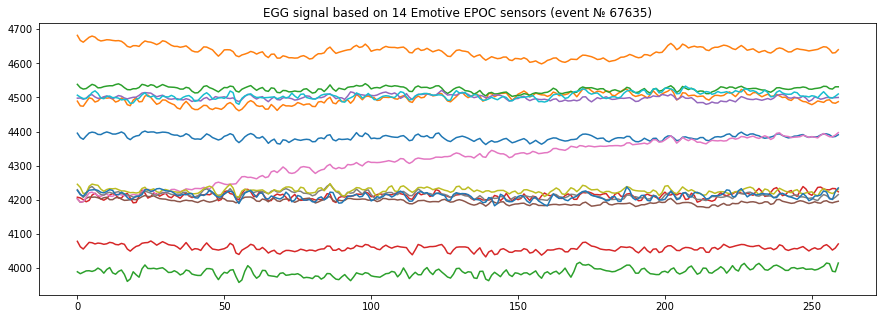

In [21]:
data_sample = df[df['event'] == 67635]
fig = plt.figure(figsize=(15, 5))
for row in data_sample['data']:
    plt.plot(row)
plt.title('EGG signal based on 14 Emotive EPOC sensors (event № 67635)')    
plt.show()  

In [22]:
np.all(df['size'].values == 260)

False

In [23]:
df['size'].value_counts().head(10)

260    606214
256    173614
264     61586
261     44072
257     12362
252      4956
265      3640
268      2884
253       294
272       196
Name: size, dtype: int64

Filter values signal length. We need events with length equal to 260.

In [24]:
# Find events with 260 length
clear_grouping = df[df['size'] == 260].groupby('event').agg({'id':'nunique'})
# Save only complete events with 14 channels (sanity check)
correct_events = clear_grouping[clear_grouping['id'] == 14].index
# Filter data
filtered_df = df[df['event'].isin(correct_events)]

In [58]:
filtered_df.head(20)

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.385, 4382.564, 4377.436, 4387.1797, 4395.8975, 4398.4614, 4396.923, 4391.795, 4391.282, 43..."
1,67636,67635,EP,F7,6,260,"[4489.231, 4475.385, 4474.359, 4486.6665, 4498.974, 4496.41, 4486.6665, 4489.7437, 4498.4614, 45..."
2,67637,67635,EP,F3,6,260,"[4538.4614, 4528.718, 4524.615, 4526.154, 4532.3076, 4538.4614, 4535.385, 4528.205, 4528.718, 45..."
3,67638,67635,EP,FC5,6,260,"[4207.6924, 4205.641, 4200.5127, 4194.359, 4198.4614, 4213.846, 4219.4873, 4210.769, 4202.564, 4..."
4,67639,67635,EP,T7,6,260,"[4497.9487, 4498.4614, 4494.8716, 4497.9487, 4506.154, 4508.205, 4501.5386, 4497.436, 4498.4614,..."
5,67640,67635,EP,P7,6,260,"[4203.077, 4192.8203, 4194.8716, 4204.615, 4208.205, 4207.6924, 4208.205, 4206.154, 4202.564, 42..."
6,67641,67635,EP,O1,6,260,"[4203.077, 4193.3335, 4194.8716, 4207.1797, 4220.5127, 4222.564, 4217.436, 4212.3076, 4210.2563,..."
7,67642,67635,EP,O2,6,260,"[4229.7437, 4216.923, 4207.1797, 4215.385, 4234.8716, 4238.974, 4230.769, 4222.564, 4215.385, 42..."
8,67643,67635,EP,P8,6,260,"[4245.641, 4236.41, 4218.4614, 4220.0, 4239.4873, 4246.154, 4244.1025, 4242.564, 4231.282, 4225...."
9,67644,67635,EP,T8,6,260,"[4506.6665, 4501.026, 4496.923, 4496.923, 4504.1025, 4514.359, 4519.4873, 4511.795, 4498.4614, 4..."


In [26]:
targets = filtered_df.groupby('event')['code'].mean().values #It is not important mean, max or min
print('Targets amount:', len(targets))

Targets amount: 43301


In [91]:
# Stack sub-arrays and transpond matrix 
stack_data = np.vstack(filtered_df['data'].values)
print(stack_data.shape)

(606214, 260)


In [92]:
complete_samples_amounts = len(filtered_df)/14
print('Samples amount (14 signals per one object): ', complete_samples_amounts)

Samples amount (14 signals per one object):  43301.0


In [94]:
# # Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stack_data)
# scaled_data = stack_data  # uncomment to skip skaling

In [95]:
# Split data in groups. One group ~ one target label
split_data = np.array(np.split(scaled_data, complete_samples_amounts, axis=0))
split_data.shape

(43301, 14, 260)

In [96]:
# Reshape 14 vectors in one
data = np.reshape(split_data, [split_data.shape[0], split_data.shape[1] * split_data.shape[2]])
data.shape

(43301, 3640)

In [97]:
# # Make final dataframe with with data - target
# result_df = pd.DataFrame(zip(data, targets), columns=['data', 'target'])
# result_df.head()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


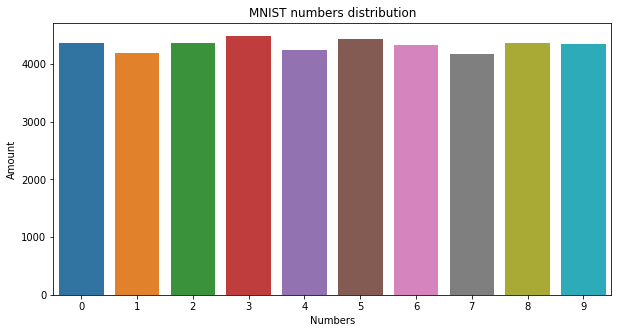

In [98]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(targets)
ax.set(xlabel='Numbers', ylabel='Amount')
plt.title('MNIST numbers distribution')
plt.show()

Dataset seems quite balanced. Let's make index partition.

In [99]:
idx_full = list(range(len(data)))

In [100]:
idx_rest, idx_val, y_rest, y_val = train_test_split(idx_full, targets, test_size=0.2, stratify=targets)
idx_train, idx_test, y_train, y_test = train_test_split(idx_rest, y_rest, test_size=0.1, stratify=y_rest)

In [101]:
print(len(y_train), len(y_val), len(y_test))

31176 8661 3464


In [102]:
X_train = data[idx_train, :]
X_valid = data[idx_val, :]
X_test = data[idx_test, :]

### Linear model

In [106]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [104]:
%%time
clf = RidgeClassifier()
clf.fit(X_train, y_train)
ridge_preds = clf.predict(X_test)
accuracy_score(ridge_preds, y_test)

CPU times: user 15.9 s, sys: 991 ms, total: 16.8 s
Wall time: 9.22 s


In [ ]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
forest_preds = clf.predict(X_test)
accuracy_score(forest_preds, y_test)

0.11922632794457275

In [ ]:
############################################################################

Data generator example: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        idx = self.list_IDs[index]

        # Load data
        X = data[idx, :, :]
        y = self.labels[index]

        return X, y

In [ ]:
training_set = Dataset(idx_train, y_train)
training_generator = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

validation_set = Dataset(idx_val, y_val)
validation_generator = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_set = Dataset(idx_test, y_test)
test_generator = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
loaders = {'train': training_generator, 'val': validation_generator, 'test': test_generator}
                      

In [ ]:
# Check sample
egg_sample, label_sample = next(iter(training_set))
print("Samples amount, ms: {}; channels amount: {}".format(*egg_sample.shape))
print("Label:", label_sample)

Samples amount, ms: 260; channels amount: 14
Label: 0


In [ ]:
# Check batch sample
batch_sample = next(iter(loaders['train']))
data_batch, target_batch = batch_sample
print('Data batch shape:', data_batch.shape)
print('Target batch shape:',target_batch.shape)

Data batch shape: torch.Size([16, 260, 14])
Target batch shape: torch.Size([16])


In [ ]:
# Define model
class Model(nn.Module):

    def __init__(self, input_size, lstm_size, lstm_layers, embedding_size, num_classes):
        # Call parent
        super().__init__()
        # Define parameters
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        # Define internal modules
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers=lstm_layers, batch_first=True)
        self.embedding = nn.Linear(lstm_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # Prepare LSTM initiale state
        batch_size = x.size(0)
        # Forward LSTM and get final state
        #print(x.shape)
        x = x.permute(1,0,2)
        x,_ = self.lstm(x)
        #print(x.shape)
        #x = x[:,-1,:]
        x = x[-1,:,:]
        #print(x.shape)
        # Forward embedding
        x = F.relu(self.embedding(x))
        # Forward classifier
        x = self.classifier(x)
        return x

In [ ]:
model = Model(14, LSTM_SIZE, LSTM_LAYERS, EMBEDDING_SIZE, NUM_CLASSES)
optimizer = getattr(torch.optim, OPTIM_NAME)(model.parameters(), lr = LR)

In [ ]:
start_epoch = 1 # default counter for traning loop

# if CHECKPOINT_NAME is not None:
#     checkpoint = torch.load(os.path.join(CHKPT_FOLDER, CHECKPOINT_NAME))
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch']
#     loss = checkpoint['loss']

In [ ]:
# Setup CUDA
if not NO_CUDA:
    model.cuda()
    print("Copied to CUDA")

# Start training
for epoch in range(start_epoch, EPOCHS+1):
    # Initialize loss/accuracy variables
    losses = {"train": 0, "val": 0, "test": 0}
    accuracies = {"train": 0, "val": 0, "test": 0}
    counts = {"train": 0, "val": 0, "test": 0}
    # Adjust learning rate for SGD
    if OPTIM_NAME == "SGD":
        lr = LR * (LR_DECAY_FACTOR ** (epoch // LR_DECAY_PERIOD))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    # Process each split
    for split in ("train", "val", "test"):
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all split batches
        for i, (input, target) in enumerate(loaders[split]):
            # Check CUDA
            if not NO_CUDA:
                input = input.cuda(async = True)
                target = target.cuda(async = True)
            # Forward
            output = model(input)
            loss = F.cross_entropy(output, target)
            losses[split] += loss.item()
            # Compute accuracy
            _,pred = output.data.max(1)
            correct = pred.eq(target.data).sum().item()
            accuracy = correct/input.data.size(0)
            accuracies[split] += accuracy
            counts[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    ## Save checkpoint
    # if epoch % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss
    #     }, os.path.join(CHKPT_FOLDER, 'vanila_lstm_chkpt_epoch_{}.pt'.format(epoch)))

    # Print info at the end of the epoch
    print("Epoch {0}: TrL={1:.4f}, TrA={2:.4f}, VL={3:.4f}, VA={4:.4f}, TeL={5:.4f}, TeA={6:.4f}".format(epoch,
                                                                                                         losses["train"]/counts["train"],
                                                                                                         accuracies["train"]/counts["train"],
                                                                                                         losses["val"]/counts["val"],
                                                                                                         accuracies["val"]/counts["val"],
                                                                                                         losses["test"]/counts["test"],
                                                                                                         accuracies["test"]/counts["test"]))

Epoch 416: TrL=2.3043, TrA=0.1016, VL=2.3041, VA=0.1007, TeL=2.3040, TeA=0.1008


KeyboardInterrupt: ignored

In [ ]:
# torch.save(model, SAVE_PATH)